<a href="https://colab.research.google.com/github/Ganesh-2250/Computer_Vision/blob/main/CV_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 335kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]


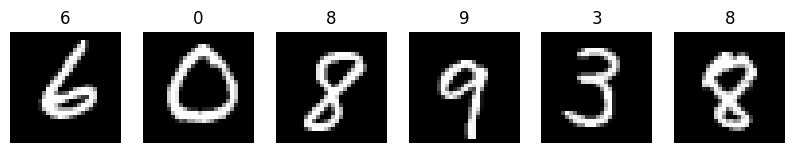

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# Visualize a few samples
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(int(labels[i]))
    axes[i].axis('off')
plt.show()


In [4]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
model = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [6]:
num_epochs = 8
losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {loss.item():.4f}")


Epoch [1/8]  Loss: 0.1628
Epoch [2/8]  Loss: 0.0534
Epoch [3/8]  Loss: 0.1658
Epoch [4/8]  Loss: 0.0919
Epoch [5/8]  Loss: 0.0324
Epoch [6/8]  Loss: 0.0286
Epoch [7/8]  Loss: 0.0798
Epoch [8/8]  Loss: 0.0424


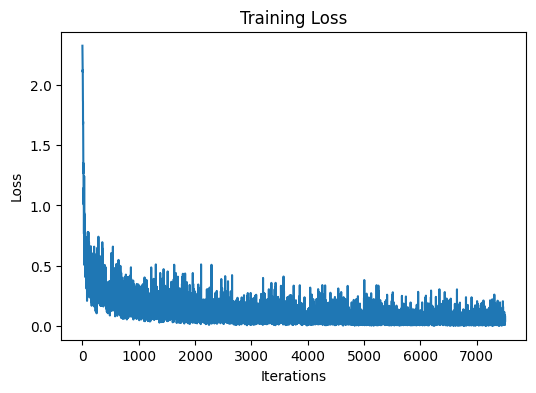

In [7]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


In [8]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 97.62%


Precision: 0.9762
Recall: 0.9759
F1-Score: 0.9760


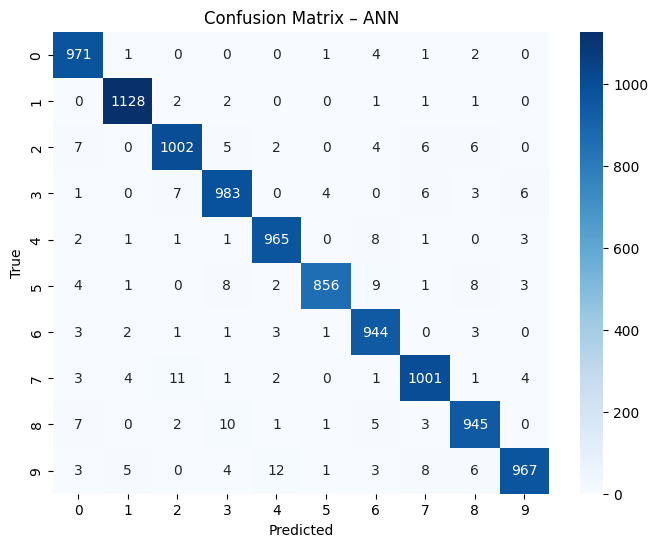

In [9]:
precision = precision_score(all_labels, all_preds, average='macro')
recall    = recall_score(all_labels, all_preds, average='macro')
f1        = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – ANN')
plt.show()


In [10]:
class ANN_Regularized(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(ANN_Regularized, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model_reg = ANN_Regularized().to(device)
criterion_reg = nn.CrossEntropyLoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001, weight_decay=1e-4)


In [11]:
num_epochs = 8
losses_reg = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model_reg(images)
        loss = criterion_reg(outputs, labels)
        optimizer_reg.zero_grad()
        loss.backward()
        optimizer_reg.step()
        losses_reg.append(loss.item())
    print(f"[Reg] Epoch {epoch+1}/{num_epochs}  Loss: {loss.item():.4f}")


[Reg] Epoch 1/8  Loss: 0.0621
[Reg] Epoch 2/8  Loss: 0.2406
[Reg] Epoch 3/8  Loss: 0.4666
[Reg] Epoch 4/8  Loss: 0.2912
[Reg] Epoch 5/8  Loss: 0.3093
[Reg] Epoch 6/8  Loss: 0.1238
[Reg] Epoch 7/8  Loss: 0.2320
[Reg] Epoch 8/8  Loss: 0.0382


Accuracy: 96.25%
Precision: 0.9626
Recall: 0.9620
F1-Score: 0.9621


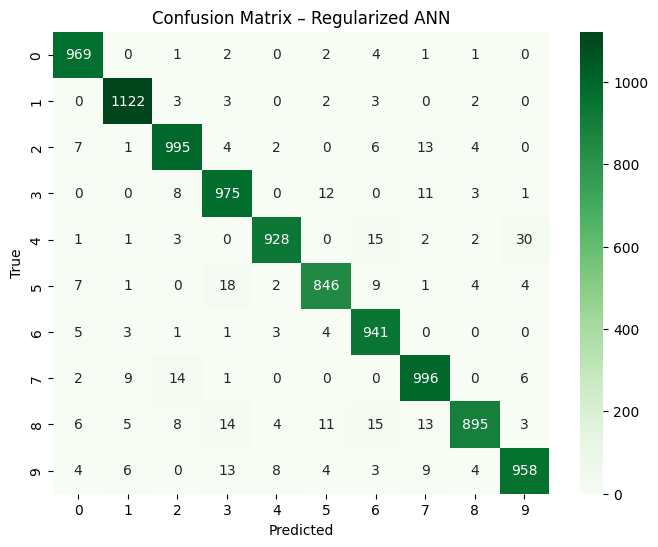

In [12]:
model_reg.eval()
all_preds_reg, all_labels_reg = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_reg(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_reg.extend(predicted.cpu().numpy())
        all_labels_reg.extend(labels.cpu().numpy())

acc_reg = accuracy_score(all_labels_reg, all_preds_reg)
prec_reg = precision_score(all_labels_reg, all_preds_reg, average='macro')
rec_reg  = recall_score(all_labels_reg, all_preds_reg, average='macro')
f1_reg   = f1_score(all_labels_reg, all_preds_reg, average='macro')

print(f"Accuracy: {acc_reg*100:.2f}%\nPrecision: {prec_reg:.4f}\nRecall: {rec_reg:.4f}\nF1-Score: {f1_reg:.4f}")

cm_reg = confusion_matrix(all_labels_reg, all_preds_reg)
plt.figure(figsize=(8,6))
sns.heatmap(cm_reg, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – Regularized ANN')
plt.show()


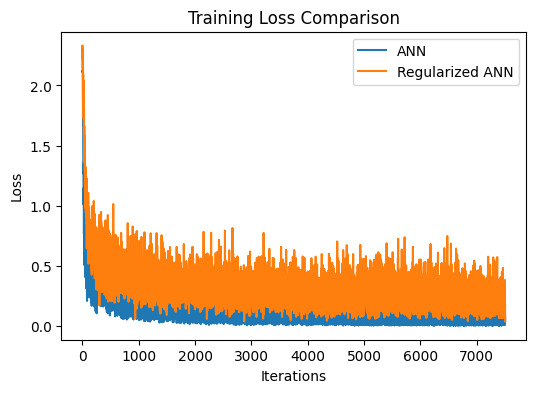

In [13]:
plt.figure(figsize=(6,4))
plt.plot(losses, label='ANN')
plt.plot(losses_reg, label='Regularized ANN')
plt.legend()
plt.title('Training Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()
